In [1]:
cd ..

D:\Kevin\Machine Learning\Cassava Leaf Disease Classification


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from adabelief_pytorch import AdaBelief
from ranger_adabelief import RangerAdaBelief
from warmup_scheduler import GradualWarmupScheduler

import timm

from src.dataset import get_loaders
from src.optim import get_optimizer_and_scheduler
from src.engine import get_device, get_net, train_one_epoch, valid_one_epoch
from src import config
from src.utils import *
from src.loss import FocalCosineLoss, SmoothCrossEntropyLoss, bi_tempered_logistic_loss

%matplotlib inline

In [3]:
from IPython.display import FileLinks
FileLinks(config.WEIGHTS_PATH)

./generated/weights\SEResNeXt50_32x4d_BH/
  SEResNeXt50_32x4d_BH_fold_2_11.bin

In [4]:
class GeneralizedCassavaClassifier(nn.Module):
    def __init__(self, model_arch, n_class=5, pretrained=False):
        super().__init__()
        self.name = model_arch
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        model_list = list(self.model.children())
        model_list[-1] = nn.Linear(
            in_features=model_list[-1].in_features,
            out_features=n_class,
            bias=True
        )
        self.model = nn.Sequential(*model_list)

    def forward(self, x):
        x = self.model(x)
        return x


net = GeneralizedCassavaClassifier(model_arch="resnext50_32x4d")

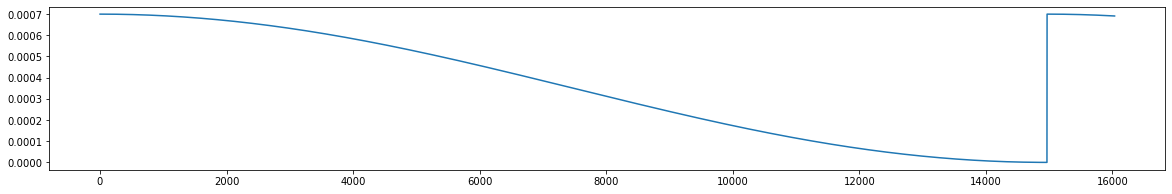

In [28]:
pull = False
fold = 0

if not pull:

    model = net
    train_loader, valid_loader          = get_loaders(fold)

    class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE * config.WARMUP_FACTOR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=5, eta_min=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=14,
                T_mult=1,
                eta_min=0,
                last_epoch=-1)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=config.WARMUP_FACTOR, total_epoch=config.WARMUP_EPOCHS, after_scheduler=scheduler)

if pull:
    train_loader, valid_loader          = get_loaders(fold)
    optimizer, scheduler                = get_optimizer_and_scheduler(net=net, dataloader=train_loader)

lrs = []
for epoch in range(config.MAX_EPOCHS):
    for step in range(len(train_loader)):
        scheduler.step(epoch + (step / len(train_loader)))
        lrs.append(optimizer.param_groups[0]["lr"])
plt.rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [16]:
for lr in lrs:
    print(lr)

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007
0.0007

In [7]:
len(train_loader) * 15

16035

In [4]:
df = pd.read_csv(TRAIN_FOLDS)
dataset = CassavaDataset(df=df,
                         data_root=TRAIN_IMAGES_DIR,
                         transforms=get_valid_transforms())
dataloader = DataLoader(dataset,
                        batch_size=3,
                        drop_last=False,
                        num_workers=0,
                        shuffle=False)
device = get_device(n=0)
net = get_net(name=NET, pretrained=False)
net.load_state_dict(torch.load("./generated/weights\SEResNeXt50_32x4d_BH/SEResNeXt50_32x4d_BH_fold_2_11.bin"))
net = net.to(device)

Device:                      GPU


In [6]:
preds = np.empty((0, 5), dtype=np.float64)
for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = net(images).detach().cpu().numpy()
    preds = np.concatenate([preds, predictions], axis=0)
    
print(preds.shape)

KeyboardInterrupt: 

In [9]:
preds = np.empty((0, 5), dtype=np.float64)